# Eval Metrics

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import json
import src.config as Config
from src.models.loader import DataModule
from torch_geometric.data import HeteroData
from torch_geometric.utils import to_torch_coo_tensor
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as ssp 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


2023-03-10 01:36:39,791 - torch.distributed.nn.jit.instantiator - INFO - Created a temporary directory at /tmp/tmpbda5iicl
2023-03-10 01:36:39,792 - torch.distributed.nn.jit.instantiator - INFO - Writing /tmp/tmpbda5iicl/_remote_module_non_scriptable.py


In [3]:
# COMMON CONSTANTS
TOP_K = 20

In [4]:
dm = DataModule(torch.device('cpu'), norm_rating=False)
train_data = dm.train_data
test_data = dm.test_data

target = to_torch_coo_tensor(
    test_data["reviews"].edge_index,
    size=[dm.num_users, dm.num_recipes],
)

def test(preds_adj: torch.Tensor):
    retrieved_and_relevant = torch.sparse.sum(preds_adj * target, dim=1).to_dense()
    retrieved = torch.sparse.sum(preds_adj, dim=1).to_dense()
    relevant = torch.sparse.sum(target, dim=1).to_dense()

    precision = (retrieved_and_relevant / retrieved).nan_to_num_(0).mean().item()
    recall = (retrieved_and_relevant / relevant).nan_to_num_(0).mean().item()

    return precision, recall

# Baseline
> For any given user, recommend the **most common** recipes in the training set

In [5]:
from torch_geometric.utils import degree

In [6]:
recipe_used = train_data['reviews'].edge_index[1]
num_recipe_uses = degree(recipe_used)

In [7]:
precision_k = []
recall_k = []
for k in range(1, TOP_K):
    preds_idx = num_recipe_uses.topk(k).indices
    preds_adj = torch.sparse_coo_tensor(
        indices=torch.vstack(
            [
                torch.arange(dm.num_users)[:, None]
                    .expand((dm.num_users, k))
                    .flatten(),
                preds_idx
                    .expand((dm.num_users, k))
                    .flatten(),

            ]
        ),
        values=torch.ones(dm.num_users * k),
        size=[dm.num_users, dm.num_recipes],
    )
    precision, recall = test(preds_adj)
    precision_k.append(precision)
    recall_k.append(recall)

<Axes: title={'center': 'CommonRec: Precision@K vs Recall@K'}, xlabel='k'>

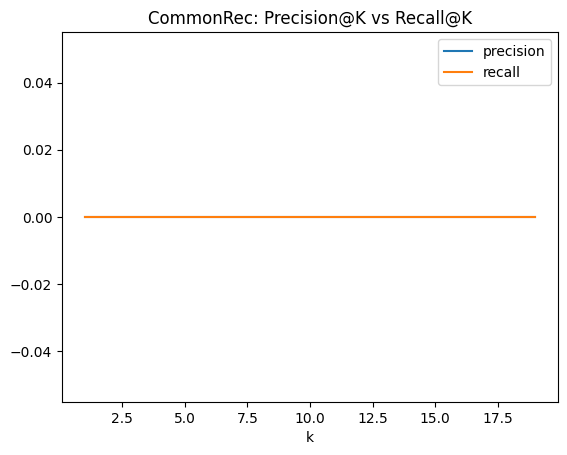

In [8]:
results_common = pd.DataFrame({
    'k': range(1, TOP_K),
    'precision': precision_k,
    'recall': recall_k,
})
results_common.plot(x='k', y=['precision', 'recall'], title='CommonRec: Precision@K vs Recall@K', xlabel='k')

# Collaberative Filtering
AKA: "Wisdom of the crowd"
> For any user, recommend recipes based on what people who cook similar things are cooking

In [9]:
from surprise import KNNWithMeans, Trainset
from collections import defaultdict

In [10]:
ur = defaultdict(list)
ir = defaultdict(list)

for (usr_id, rcp_id), rating in zip(
    train_data['reviews'].edge_index.T.numpy(),
    train_data['reviews'].edge_attr.numpy()
):
    ur[usr_id].append((rcp_id, rating))
    ir[rcp_id].append((usr_id, rating))

train_sup = Trainset(
    ur,
    ir,
    dm.num_users,
    dm.num_recipes,
    train_data['reviews'].edge_index.size(1),
    (0, 5),
    { i: i for i in range(dm.num_users) }, 
    { i: i for i in range(dm.num_recipes) }, 
)

In [11]:
cf = KNNWithMeans(
    sim_options={
        "name": "pearson",
        "user_based": True
    }
)

cf.fit(train_sup)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [12]:
from tqdm.notebook import tqdm

In [17]:
def get_top_preds_for_user(usr_id, k: int):
    preds = torch.tensor([cf.predict(usr_id, rcp_id).est for rcp_id in range(dm.num_recipes)])
    return preds.topk(k).indices

# Only sample 200 users, else this takes 8hrs
# usr_ids = np.random.randint(dm.num_users, size=200)
usr_ids = torch.randint(high=dm.num_users, size=(200,))
preds = torch.vstack(
    [get_top_preds_for_user(x.item(), TOP_K) for x in tqdm(usr_ids)]
)
preds

  0%|          | 0/200 [00:00<?, ?it/s]

tensor([[150704, 154140, 212718,  ...,     28,     23,     13],
        [ 63127,     30,     31,  ...,     50,     29,      2],
        [165864,  66687,  58516,  ...,     23,     13,     50],
        ...,
        [    31,     10,     30,  ...,     29,      2,      6],
        [ 13054,  11680,  23559,  ...,  23665,    527,    106],
        [   256,    878,   1166,  ...,   1163,    849,     53]])

In [18]:
precision_k = []
recall_k = []
for k in range(1, TOP_K):
    recs = torch.sparse_coo_tensor(
        indices=torch.vstack(
            [
                usr_ids[:, None]
                .expand((usr_ids.size(0), k))
                .flatten(),
                preds[:, :k].flatten(),
            ]
        ),
        values=torch.ones(preds[:, :k].numel()),
        size=[dm.num_users, dm.num_recipes],
    )
    precision, recall = test(preds_adj)
    precision_k.append(precision)
    recall_k.append(recall)

<Axes: title={'center': 'Collaberative Filtering: Precision@K vs Recall@K'}, xlabel='k'>

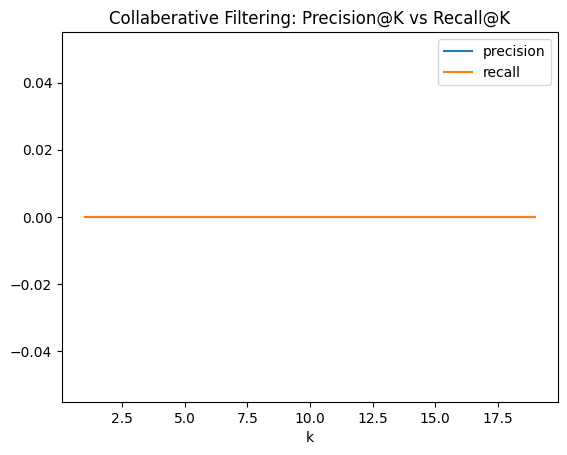

In [19]:
results_cf = pd.DataFrame({
    'k': range(1, TOP_K),
    'precision': precision_k,
    'recall': recall_k,
})
results_cf.plot(x='k', y=['precision', 'recall'], title='Collaberative Filtering: Precision@K vs Recall@K', xlabel='k')

# HeteroLGN
A modified version of LightGCN designed to work with heterogeneous/biparite graphs

In [20]:
from src.models.heterolgn import HeteroLGN
dm = DataModule(torch.device('cpu'), norm_rating=True)
train_data = dm.train_data
test_data = dm.test_data

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
test_device_data = test_data.to(device)

def eval_model(model: nn.Module):
    model.to(device)
    model.eval()
    usr_out, rec_out = model(
        x_dict=test_device_data.x_dict,
        edge_index_dict=test_device_data.edge_index_dict,
        edge_weight_dict=test_device_data.edge_attr_dict,
    )

    batch_cutoffs = list(range(0, dm.num_users, dm.num_users // 10))
    batch_cutoffs.append(dm.num_users)

    precision_k = []
    recall_k = []
    for k in range(1, TOP_K):
        # Need to do this in batches, otherwise we run out of memory
        recs = []
        for start, end in zip(batch_cutoffs, batch_cutoffs[1:]):
            scores = usr_out[start:end] @ rec_out.T
            recs.append(scores.topk(k, dim=-1).indices)
        recs = torch.concat(recs, dim=0)
        recs = torch.sparse_coo_tensor(
            indices=torch.vstack(
                [
                    torch.arange(dm.num_users, device=recs.device)[:, None]
                    .expand_as(recs)
                    .flatten(),
                    recs.flatten(),
                ]
            ),
            values=torch.ones(recs.numel()),
            size=[dm.num_users, dm.num_recipes],
            device=recs.device,
        )

        precision, recall = test(recs.to(torch.device('cpu')))
        precision_k.append(precision)
        recall_k.append(recall)
    
    return pd.DataFrame({
        'k': range(1, TOP_K),
        'precision': precision_k,
        'recall': recall_k,
    })

## Model \#1
- $2000$ Iterations
- $0.1$ LR
- $0$ $\lambda$
- $16$ embed dim

In [22]:
model_path = Path(Config.MODEL_DIR) / '230309-055114'
hp = json.load((model_path / 'hp.json').open())
model = HeteroLGN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'HeteroLGN: Precision@K vs Recall@K'}, xlabel='k'>

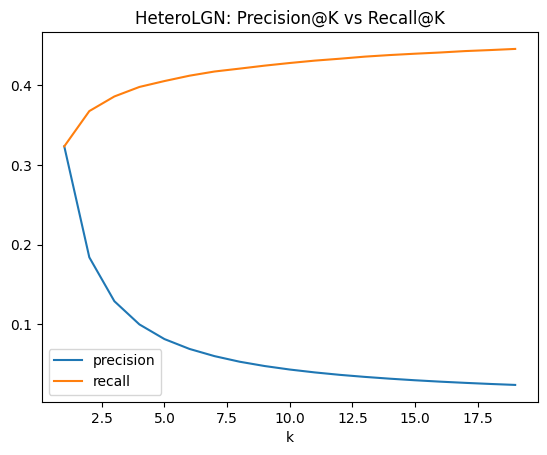

In [23]:
results1 = eval_model(model)
results1.plot(x='k', y=['precision', 'recall'], title='HeteroLGN: Precision@K vs Recall@K', xlabel='k')

## Model \#2
- $2000$ Iterations
- $0.1$ LR
- $0$ $\lambda$
- $32$ embed dim

In [24]:
model_path = Path(Config.MODEL_DIR) / '230309-003845'
hp = json.load((model_path / 'hp.json').open())
model = HeteroLGN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'HeteroLGN: Precision@K vs Recall@K'}, xlabel='k'>

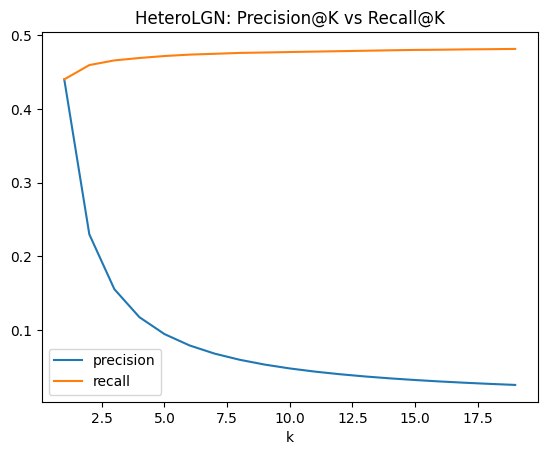

In [25]:
results2 = eval_model(model)
results2.plot(x='k', y=['precision', 'recall'], title='HeteroLGN: Precision@K vs Recall@K', xlabel='k')

# RecLGN

In [26]:
from src.models.reclcn import RecLGN

## Model \#1
- Embed Dim: 0
- Use Weights: False
- Use Recipe Data: True

In [27]:
model_path = Path(Config.MODEL_DIR) / '230309-084010'
hp = json.load((model_path / 'hp.json').open())
model = RecLGN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    recipe_dim=dm.recipe_dim,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
    use_weights=hp["use_weights"],
    use_recipe_data=hp["use_recipe_data"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'RecLGN: Precision@K vs Recall@K'}, xlabel='k'>

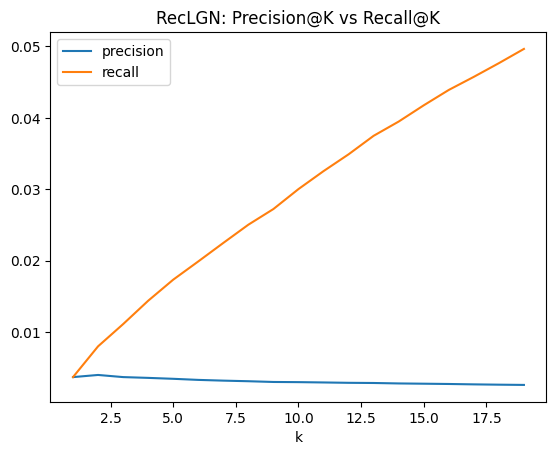

In [28]:
results3 = eval_model(model)
results3.plot(x='k', y=['precision', 'recall'], title='RecLGN: Precision@K vs Recall@K', xlabel='k')

## Model \#2
- Embed Dim: 16
- Use Weights: False
- Use Recipe Data: True

In [29]:
model_path = Path(Config.MODEL_DIR) / '230309-214324'
hp = json.load((model_path / 'hp.json').open())
model = RecLGN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    recipe_dim=dm.recipe_dim,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
    use_weights=hp["use_weights"],
    use_recipe_data=hp["use_recipe_data"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'RecLGN: Precision@K vs Recall@K'}, xlabel='k'>

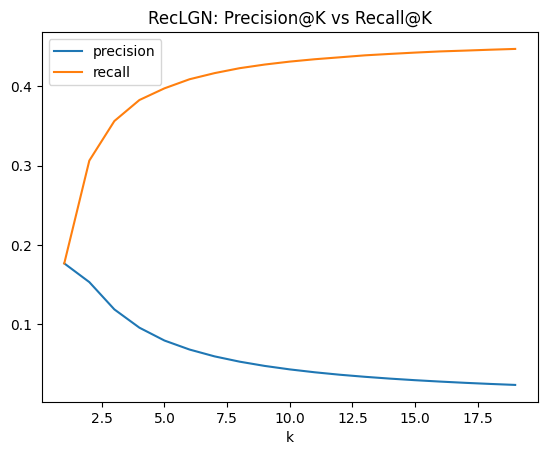

In [30]:
results4 = eval_model(model)
results4.plot(x='k', y=['precision', 'recall'], title='RecLGN: Precision@K vs Recall@K', xlabel='k')

## Model \#3
- Embed Dim: 16
- Use Weights: True
- Use Recipe Data: False

In [31]:
model_path = Path(Config.MODEL_DIR) / '230309-215953'
hp = json.load((model_path / 'hp.json').open())
model = RecLGN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    recipe_dim=dm.recipe_dim,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
    use_weights=hp["use_weights"],
    use_recipe_data=hp["use_recipe_data"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'RecLGN: Precision@K vs Recall@K'}, xlabel='k'>

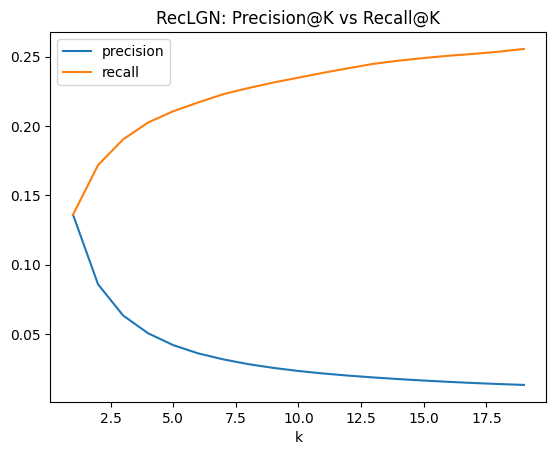

In [32]:
results5 = eval_model(model)
results5.plot(x='k', y=['precision', 'recall'], title='RecLGN: Precision@K vs Recall@K', xlabel='k')

## Model \#4
- Embed Dim: 16
- Use Weights: True
- Use Recipe Data: True

In [33]:
model_path = Path(Config.MODEL_DIR) / '230309-220855'
hp = json.load((model_path / 'hp.json').open())
model = RecLGN(
    num_users=dm.num_users,
    num_recipes=dm.num_recipes,
    recipe_dim=dm.recipe_dim,
    lambda_val=hp["lambda_val"],
    embedding_dim=hp["embed_dim"],
    use_weights=hp["use_weights"],
    use_recipe_data=hp["use_recipe_data"],
)
state_dict = torch.load(model_path / 'model.pt')
model.load_state_dict(state_dict)

<All keys matched successfully>

<Axes: title={'center': 'RecLGN: Precision@K vs Recall@K'}, xlabel='k'>

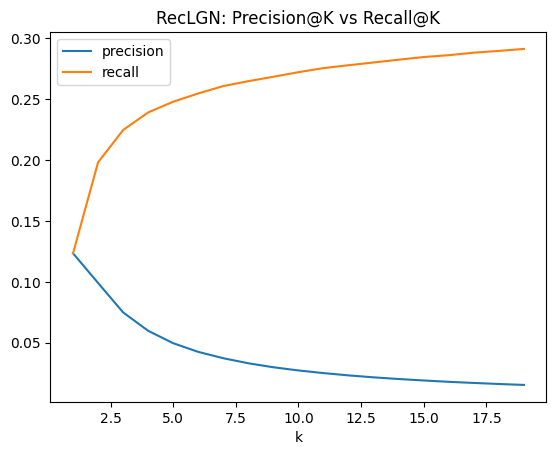

In [34]:
results6 = eval_model(model)
results6.plot(x='k', y=['precision', 'recall'], title='RecLGN: Precision@K vs Recall@K', xlabel='k')

# Final Figure Making

In [55]:
plt.rcParams['figure.figsize'] = [10, 8]

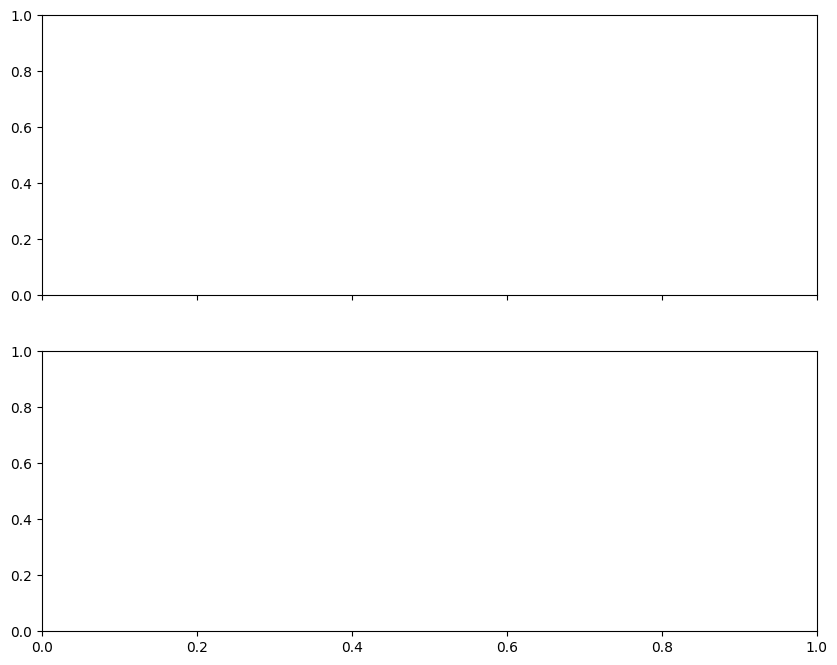

In [56]:
fig, ax = plt.subplots(2, 1, sharex=True);

## Precision

In [57]:
precision_df = pd.DataFrame({
    'k': range(1, TOP_K),
    'Collaberative Filering': results_cf.precision,
    'GCN (latent_dim=16)': results1.precision,
    'GCN (latent_dim=32)': results2.precision,
    'GCN (opposite_embedding)': results3.precision,
    'GCN (latent_dim=16 + opposite_embedding)': results4.precision,
}).plot(
    ax=ax[0],
    x='k',
    ylabel='Precision',
    title='Precision@K',
)

In [58]:
recall_df = pd.DataFrame({
    'k': range(1, TOP_K),
    'Collaberative Filering': results_cf.recall,
    'GCN (latent_dim=16)': results1.recall,
    'GCN (latent_dim=32)': results2.recall,
    'GCN (opposite_embedding)': results3.recall,
    'GCN (latent_dim=16 + opposite_embedding)': results4.recall,
}).plot(
    ax=ax[1],
    x='k',
    ylabel='Recall',
    title='Recall@K',
)

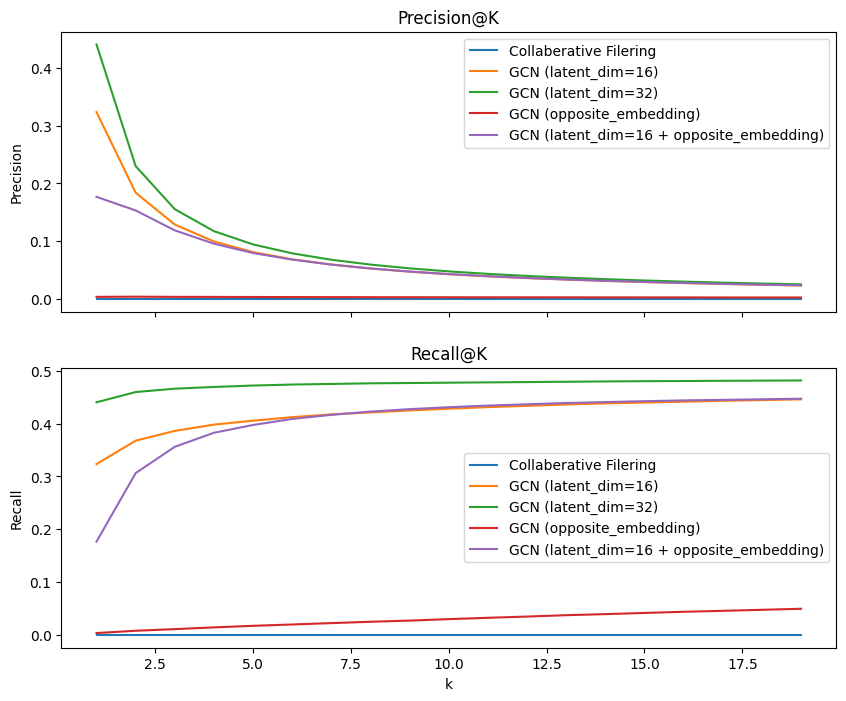

In [63]:
fig.savefig(
    '../reports/figures/model_eval.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight',
)
fig

## Hyperparam

<Axes: title={'center': 'Recall@K'}, xlabel='k', ylabel='Recall'>

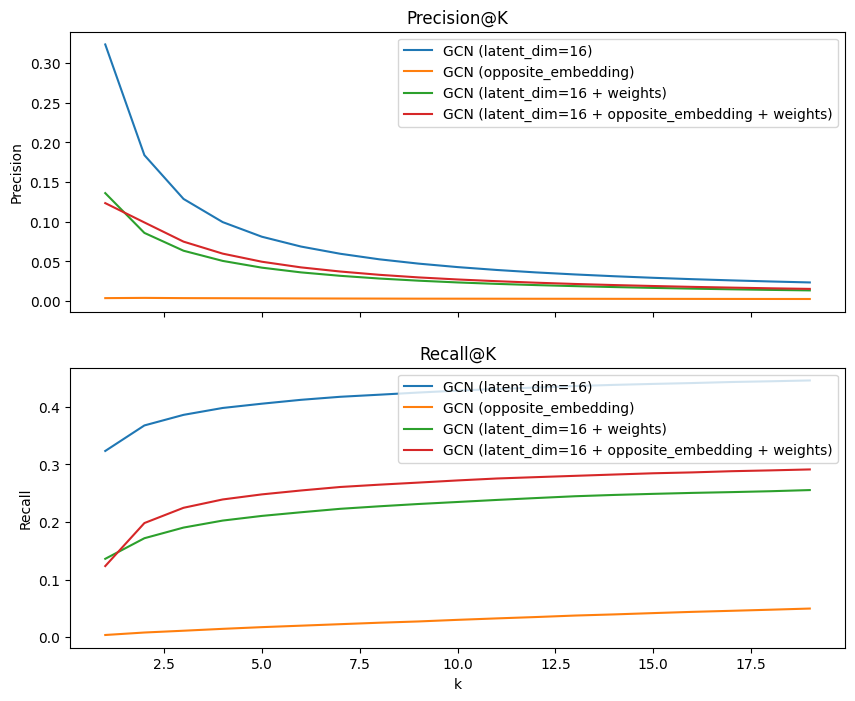

In [66]:
fig, ax = plt.subplots(2, 1, sharex=True);
pd.DataFrame({
    'k': range(1, TOP_K),
    'GCN (latent_dim=16)': results1.precision,
    'GCN (opposite_embedding)': results3.precision,
    'GCN (latent_dim=16 + weights)': results5.precision,
    'GCN (latent_dim=16 + opposite_embedding + weights)': results6.precision,
}).plot(
    ax=ax[0],
    x='k',
    ylabel='Precision',
    title='Precision@K',
)

pd.DataFrame({
    'k': range(1, TOP_K),
    'GCN (latent_dim=16)': results1.recall,
    'GCN (opposite_embedding)': results3.recall,
    'GCN (latent_dim=16 + weights)': results5.recall,
    'GCN (latent_dim=16 + opposite_embedding + weights)': results6.recall,
}).plot(
    ax=ax[1],
    x='k',
    ylabel='Recall',
    title='Recall@K',
)

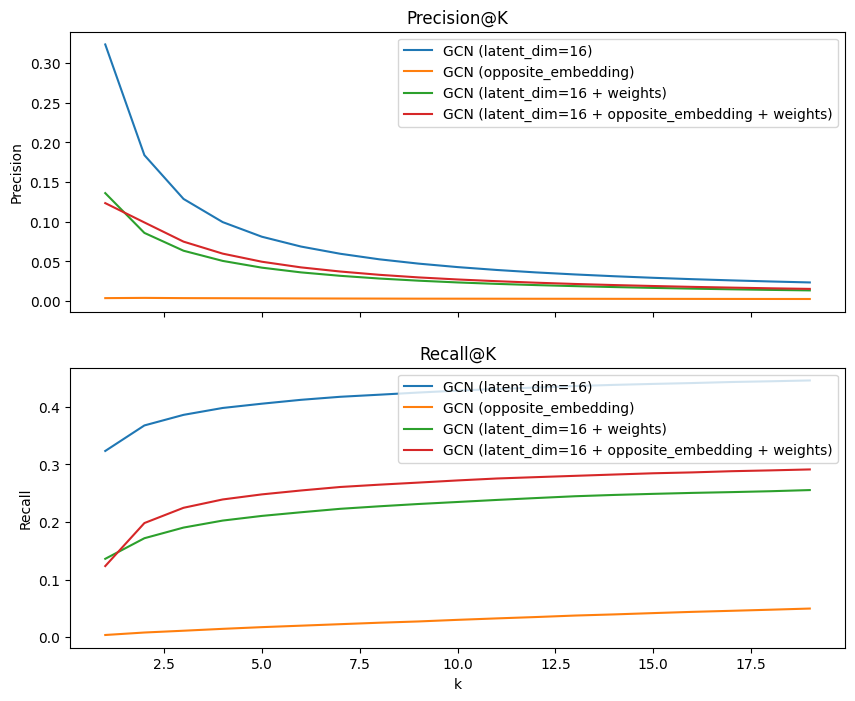

In [67]:
fig.savefig(
    '../reports/figures/flag_eval.png',
    dpi=300,
    transparent=True,
    bbox_inches='tight',
)
fig